In [37]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-


# Machine Learning

## Session 14d

### OpenVINO Tensorflow Model

<img src='../../prasami_images/prasami_color_tutorials_small.png' style = 'width:400px;' alt="By Pramod Sharma : pramod.sharma@prasami.com" align="left"/>

In [38]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from openvino.runtime import Core

from IPython.display import Markdown, display

In [39]:
# Some Basic Parameters for housekeeping

# set location of input files:
inpDir = os.path.join('..', '..', 'input')

# set location of inputs for this module
moduleDir = 'machine_learning'

# set location of inputs for this module
subDir = 'vino'

# set location of output files
outDir = os.path.join('..', 'output')

# set location of model files
modelDir = os.path.join('..', 'models')

# define and set random state 
RANDOM_STATE = 24
np.random.seed(RANDOM_STATE) # Set Random Seed for reproducible  results

# parameters for Matplotlib
params = {'legend.fontsize': 'large',
          'figure.figsize': (15, 9),
          'axes.labelsize': 'large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'large',
          'savefig.dpi': 75,
          'image.interpolation': 'none',
          'savefig.bbox' : 'tight',
          'lines.linewidth' : 1,
          'legend.numpoints' : 1
         }

CMAP = plt.cm.brg
plt.rcParams.update(params);
plt.set_cmap(CMAP);

plt.style.use('bmh')

TEST_SIZE = 0.2

<Figure size 1500x900 with 0 Axes>

In [40]:
base_model_dir = os.path.join(modelDir, 'flower_photos')# expand the path as per the os and environment

model_name = "students_base_flowers.keras"
model_path = os.path.join(base_model_dir, model_name)

In [41]:
## Load model
model = tf.keras.models.load_model(model_path)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 190, 190, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 188, 188, 32)      896       
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 94, 94, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 92, 92, 64)        18496     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 46, 46, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 44, 44, 128)      

In [42]:
tf.saved_model.save(model,base_model_dir)

INFO:tensorflow:Assets written to: ../models/flower_photos/assets


INFO:tensorflow:Assets written to: ../models/flower_photos/assets


In [43]:
print(model.layers[0].name, model.layers[0].get_input_shape_at(0))
print(model.layers[-1].name, model.layers[-1].get_output_at(0).name)

rescaling_1 (None, 190, 190, 3)
dense_5 dense_5/BiasAdd:0


In [44]:
# Construct the command for Model Optimizer.
#mo_command = f'mo --saved_model_dir ../models/flower_photos/  --input_shape=\[2,190,190,3\]'
mo_command = f'mo --saved_model_dir ../models/flower_photos/'
                 
mo_command = " ".join(mo_command.split())

print("Model Optimizer command to convert the Tensorflow model to OpenVINO:")
display(Markdown(f"`{mo_command}`"))

Model Optimizer command to convert the Tensorflow model to OpenVINO:


`mo --saved_model_dir ../models/flower_photos/`

In [45]:
mo_result = %sx $mo_command
print("\n".join(mo_result))

2024-06-18 08:39:13.728285: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-18 08:39:13.728328: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-18 08:39:13.729276: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-18 08:39:14.480046: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
[ INFO ] Generated IR will be compressed to FP16. If you get lower accuracy, please consider disabling compression explicitly by adding argument --compress_to_fp16=False.
Find more information about compression to FP16 at https://docs.openvi

In [46]:
ie = Core()

model = ie.read_model(model='saved_model.xml')
compiled_model = ie.compile_model(model=model, device_name='CPU')

input_layer_ir = compiled_model.input(0)
output_layer_ir = compiled_model.output('dense_5')

In [47]:
input_layer_ir, output_layer_ir

(<ConstOutput: names[rescaling_1_input] shape[?,190,190,3] type: f32>,
 <ConstOutput: names[dense_5] shape[?,5] type: f32>)

## Load an Image

In [48]:
# Text detection models expect an image in BGR format.
image = cv2.imread(filename=os.path.join(inpDir,'flower_photos/roses/15277801151_5ed88f40f0_n.jpg'))

image.shape

(248, 320, 3)

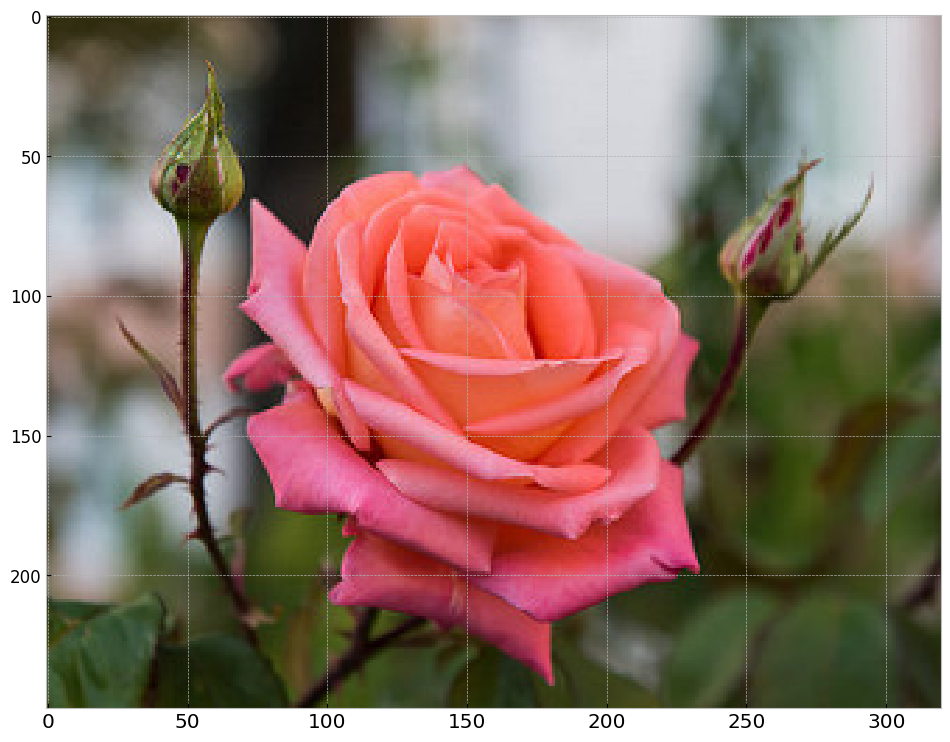

In [49]:
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB));

In [50]:
#input_layer_ir.shape

In [51]:
# N,C,H,W = batch size, number of channels, height, width.
N, H, W, C  = 1,190,190,3
N, H, W, C

(1, 190, 190, 3)

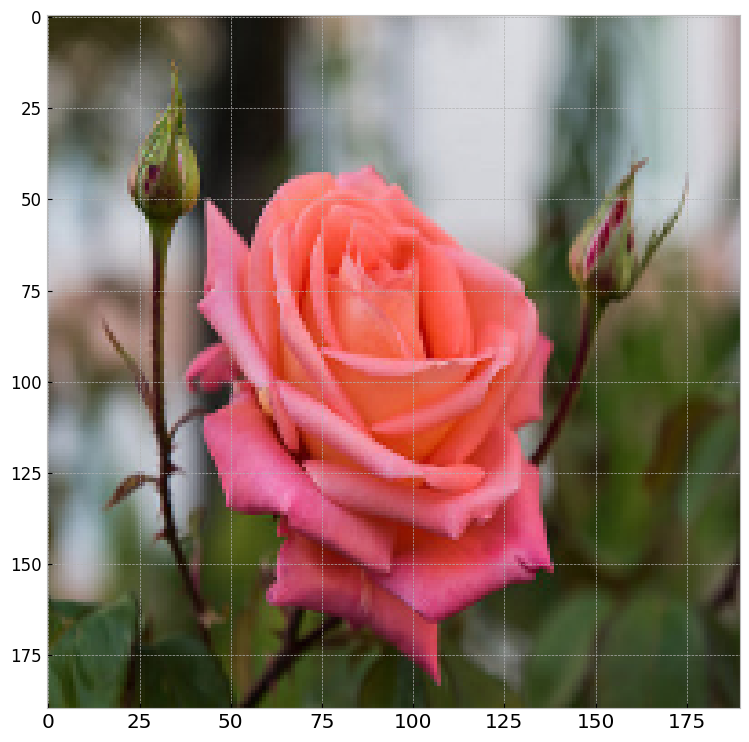

In [52]:
# Resize the image to meet network expected input sizes.
resized_image = cv2.resize(image, (W, H))
plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB));

In [53]:
input_image = np.expand_dims(resized_image, 0)
input_image.shape

(1, 190, 190, 3)

## Inference

In [54]:
# Create an inference request.
y_pred = compiled_model([input_image])[output_layer_ir]
y_pred

array([[ 0.11949465, -0.24661869,  0.5761453 , -1.063913  ,  0.21198785]],
      dtype=float32)

In [55]:
y_pred.argmax()

2

In [56]:
flower_names = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
res = flower_names[y_pred.argmax()]
res

'roses'